NBEATS EXAMPLE
https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
It's a toy example to show how to do time series forecasting using N-Beats.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os

from trainer import * # some import from the trainer script e.g. load/save functions.

# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
# It's a toy example to show how to do time series forecasting using N-Beats.

In [2]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x_full, y_full, bs):
    def split(arr, size):
        arrays = []
        while len(arr) > size:
            slice_ = arr[:size]
            arrays.append(slice_)
            arr = arr[size:]
        arrays.append(arr)
        return arrays

    while True:
        for rr in split((x_full, y_full), bs):
            yield rr

In [3]:
# trainer
def train_100_grad_steps(data, device, net, optimiser, test_losses):
    global_step = load(net, optimiser)
    for x_train_batch, y_train_batch in data:
        global_step += 1
        optimiser.zero_grad()
        net.train()
        _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(device))
        loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(device))
        loss.backward()
        optimiser.step()
        if global_step % 30 == 0:
            print(f'grad_step = {str(global_step).zfill(6)}, tr_loss = {loss.item():.6f}, te_loss = {test_losses[-1]:.6f}')
        if global_step > 0 and global_step % 100 == 0:
            with torch.no_grad():
                save(net, optimiser, global_step)
            break

In [4]:
# evaluate model on test data and produce some plots.
def eval_test(backcast_length, forecast_length, net, norm_constant, test_losses, x_test, y_test):
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    test_losses.append(F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item())
    p = forecast.detach().numpy()
    subplots = [221, 222, 223, 224]
    plt.figure(1)
    for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
        ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
        plt.subplot(subplots[plot_id])
        plt.grid()
        plot_scatter(range(0, backcast_length), xx, color='b')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
    plt.show()

In [5]:
# main
os.remove('nbeats-training-checkpoint.th')
device = torch.device('cpu')  # use the trainer.py to run on GPU.
forecast_length = 5
backcast_length = 3 * forecast_length
batch_size = 10  # greater than 4 for viz

milk = pd.read_csv('milk.csv', index_col=0, parse_dates=True)

print(milk.head())
milk = milk.values  # just keep np array here for simplicity.
norm_constant = np.max(milk)
milk = milk / norm_constant  # small leak to the test set here.

x_train_batch, y = [], []
for i in range(backcast_length, len(milk) - forecast_length):
    x_train_batch.append(milk[i - backcast_length:i])
    y.append(milk[i:i + forecast_length])

x_train_batch = np.array(x_train_batch)[..., 0]
y = np.array(y)[..., 0]

c = int(len(x_train_batch) * 0.8)
x_train, y_train = x_train_batch[:c], y[:c]
x_test, y_test = x_train_batch[c:], y[c:]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727
(118, 15) (30, 15)
(118, 5) (30, 5)


In [6]:
# model
net = NBeatsNet(stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
                forecast_length=forecast_length,
                thetas_dims=[7, 8],
                nb_blocks_per_stack=3,
                backcast_length=backcast_length,
                hidden_layer_units=128,
                share_weights_in_stack=False,
                device=device)
optimiser = optim.Adam(net.parameters())

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @4941790344
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @4941787488
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @4941788216
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @4941790512
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @4941804096
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @4941803928


In [7]:
# data
data = data_generator(x_train, y_train, batch_size)

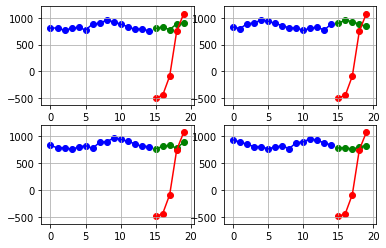

grad_step = 000030, tr_loss = 0.009205, te_loss = 0.958985
grad_step = 000060, tr_loss = 0.006806, te_loss = 0.958985
grad_step = 000090, tr_loss = 0.005950, te_loss = 0.958985


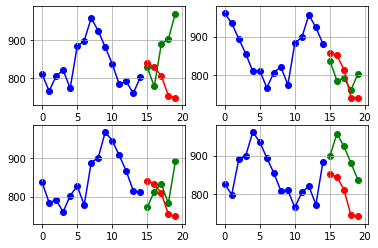

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000120, tr_loss = 0.005386, te_loss = 0.009517
grad_step = 000150, tr_loss = 0.004171, te_loss = 0.009517
grad_step = 000180, tr_loss = 0.002385, te_loss = 0.009517


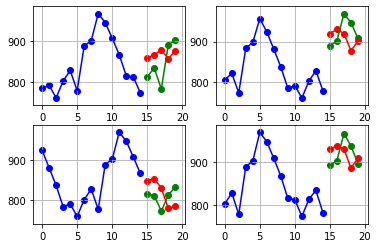

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000210, tr_loss = 0.001299, te_loss = 0.002452
grad_step = 000240, tr_loss = 0.000803, te_loss = 0.002452
grad_step = 000270, tr_loss = 0.000659, te_loss = 0.002452
grad_step = 000300, tr_loss = 0.000577, te_loss = 0.002452


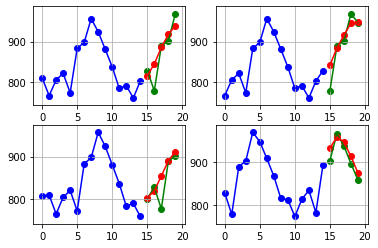

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000330, tr_loss = 0.000529, te_loss = 0.000840
grad_step = 000360, tr_loss = 0.000499, te_loss = 0.000840
grad_step = 000390, tr_loss = 0.000478, te_loss = 0.000840


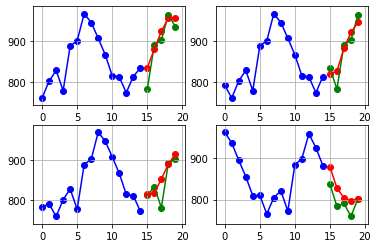

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000420, tr_loss = 0.000467, te_loss = 0.000769
grad_step = 000450, tr_loss = 0.000447, te_loss = 0.000769
grad_step = 000480, tr_loss = 0.000427, te_loss = 0.000769


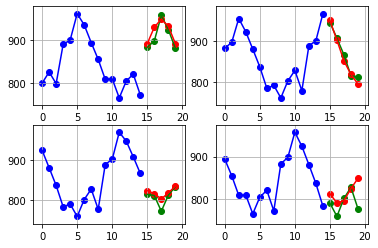

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000510, tr_loss = 0.000415, te_loss = 0.000756
grad_step = 000540, tr_loss = 0.000404, te_loss = 0.000756
grad_step = 000570, tr_loss = 0.000414, te_loss = 0.000756
grad_step = 000600, tr_loss = 0.000394, te_loss = 0.000756


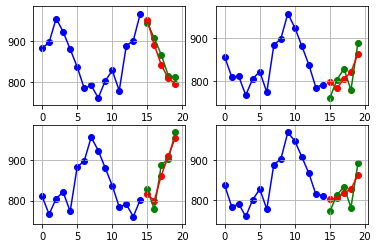

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000630, tr_loss = 0.000410, te_loss = 0.000592
grad_step = 000660, tr_loss = 0.000380, te_loss = 0.000592
grad_step = 000690, tr_loss = 0.000363, te_loss = 0.000592


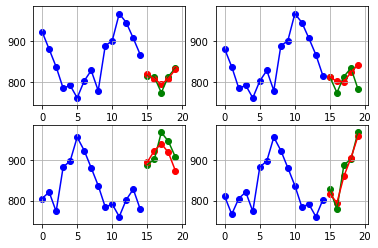

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000720, tr_loss = 0.000354, te_loss = 0.000546
grad_step = 000750, tr_loss = 0.000349, te_loss = 0.000546
grad_step = 000780, tr_loss = 0.000347, te_loss = 0.000546


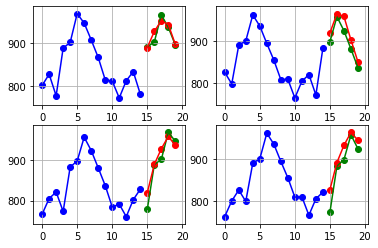

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000810, tr_loss = 0.000404, te_loss = 0.000621
grad_step = 000840, tr_loss = 0.000320, te_loss = 0.000621
grad_step = 000870, tr_loss = 0.000309, te_loss = 0.000621
grad_step = 000900, tr_loss = 0.000309, te_loss = 0.000621


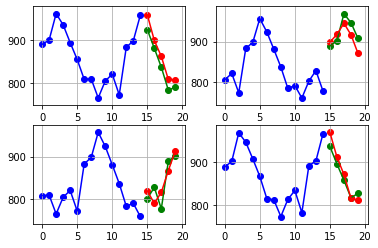

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000930, tr_loss = 0.000334, te_loss = 0.000471
grad_step = 000960, tr_loss = 0.000282, te_loss = 0.000471
grad_step = 000990, tr_loss = 0.000286, te_loss = 0.000471


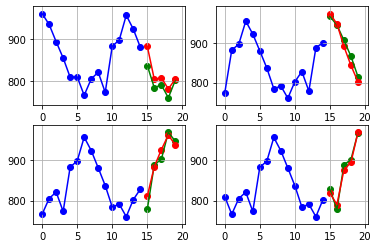

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001020, tr_loss = 0.000264, te_loss = 0.000509
grad_step = 001050, tr_loss = 0.000264, te_loss = 0.000509
grad_step = 001080, tr_loss = 0.000247, te_loss = 0.000509


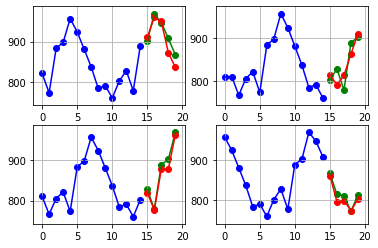

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001110, tr_loss = 0.000249, te_loss = 0.000406
grad_step = 001140, tr_loss = 0.000362, te_loss = 0.000406
grad_step = 001170, tr_loss = 0.000225, te_loss = 0.000406
grad_step = 001200, tr_loss = 0.000255, te_loss = 0.000406


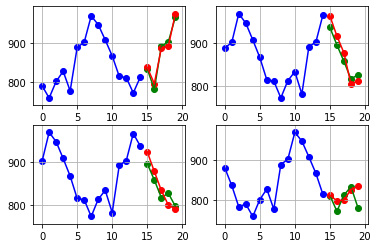

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001230, tr_loss = 0.000216, te_loss = 0.000385
grad_step = 001260, tr_loss = 0.000280, te_loss = 0.000385
grad_step = 001290, tr_loss = 0.000198, te_loss = 0.000385


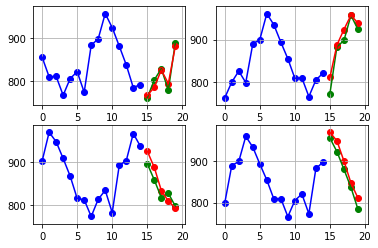

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001320, tr_loss = 0.000201, te_loss = 0.000385
grad_step = 001350, tr_loss = 0.000199, te_loss = 0.000385
grad_step = 001380, tr_loss = 0.000185, te_loss = 0.000385


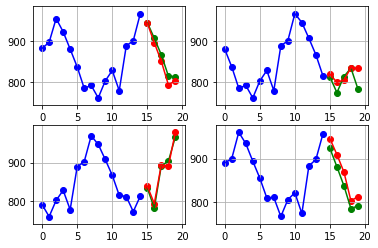

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001410, tr_loss = 0.000218, te_loss = 0.000340
grad_step = 001440, tr_loss = 0.000174, te_loss = 0.000340
grad_step = 001470, tr_loss = 0.000181, te_loss = 0.000340
grad_step = 001500, tr_loss = 0.000206, te_loss = 0.000340


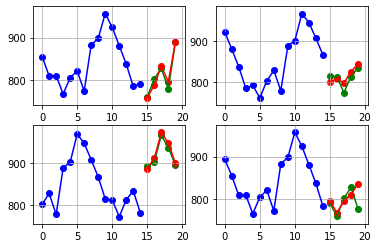

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001530, tr_loss = 0.000241, te_loss = 0.000351
grad_step = 001560, tr_loss = 0.000157, te_loss = 0.000351
grad_step = 001590, tr_loss = 0.000163, te_loss = 0.000351


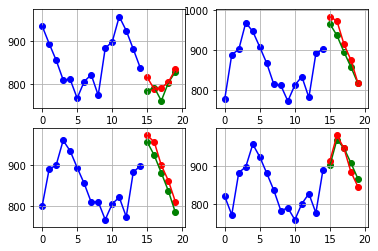

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001620, tr_loss = 0.000179, te_loss = 0.000358
grad_step = 001650, tr_loss = 0.000195, te_loss = 0.000358
grad_step = 001680, tr_loss = 0.000188, te_loss = 0.000358


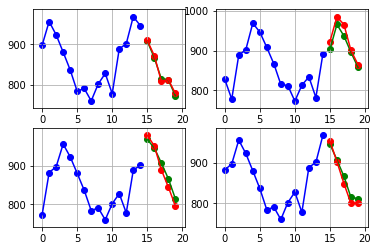

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001710, tr_loss = 0.000145, te_loss = 0.000371
grad_step = 001740, tr_loss = 0.000165, te_loss = 0.000371
grad_step = 001770, tr_loss = 0.000192, te_loss = 0.000371
grad_step = 001800, tr_loss = 0.000140, te_loss = 0.000371


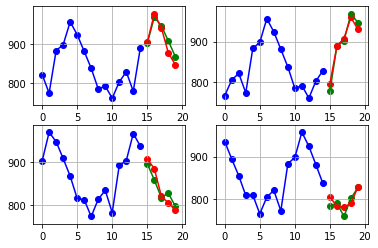

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001830, tr_loss = 0.000224, te_loss = 0.000261
grad_step = 001860, tr_loss = 0.000141, te_loss = 0.000261
grad_step = 001890, tr_loss = 0.000145, te_loss = 0.000261


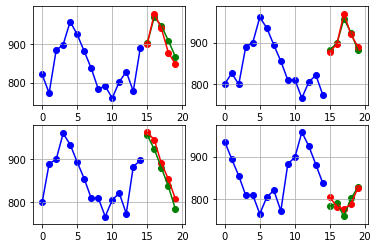

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001920, tr_loss = 0.000152, te_loss = 0.000243
grad_step = 001950, tr_loss = 0.000181, te_loss = 0.000243
grad_step = 001980, tr_loss = 0.000124, te_loss = 0.000243


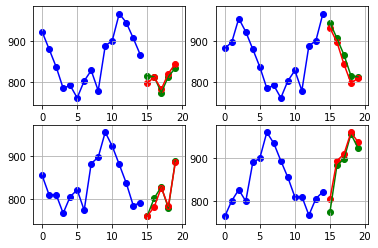

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002010, tr_loss = 0.000121, te_loss = 0.000245
grad_step = 002040, tr_loss = 0.000129, te_loss = 0.000245
grad_step = 002070, tr_loss = 0.000116, te_loss = 0.000245
grad_step = 002100, tr_loss = 0.000168, te_loss = 0.000245


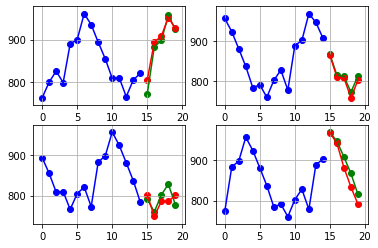

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002130, tr_loss = 0.000194, te_loss = 0.000277
grad_step = 002160, tr_loss = 0.000118, te_loss = 0.000277
grad_step = 002190, tr_loss = 0.000119, te_loss = 0.000277


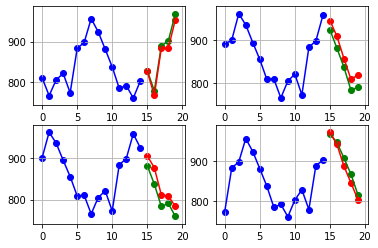

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002220, tr_loss = 0.000120, te_loss = 0.000250
grad_step = 002250, tr_loss = 0.000134, te_loss = 0.000250
grad_step = 002280, tr_loss = 0.000114, te_loss = 0.000250


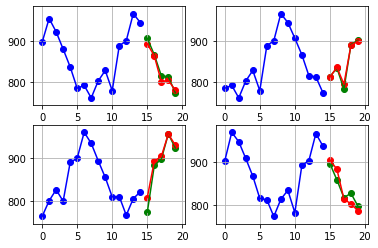

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002310, tr_loss = 0.000209, te_loss = 0.000224
grad_step = 002340, tr_loss = 0.000109, te_loss = 0.000224
grad_step = 002370, tr_loss = 0.000119, te_loss = 0.000224
grad_step = 002400, tr_loss = 0.000118, te_loss = 0.000224


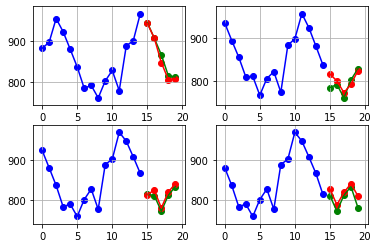

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002430, tr_loss = 0.000116, te_loss = 0.000274
grad_step = 002460, tr_loss = 0.000123, te_loss = 0.000274
grad_step = 002490, tr_loss = 0.000120, te_loss = 0.000274


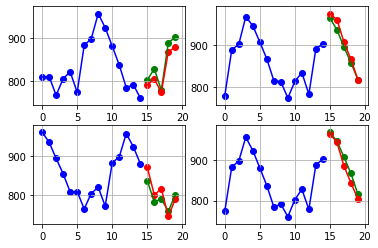

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002520, tr_loss = 0.000142, te_loss = 0.000243
grad_step = 002550, tr_loss = 0.000103, te_loss = 0.000243
grad_step = 002580, tr_loss = 0.000086, te_loss = 0.000243


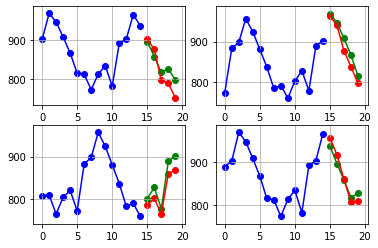

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002610, tr_loss = 0.000141, te_loss = 0.000324
grad_step = 002640, tr_loss = 0.000091, te_loss = 0.000324
grad_step = 002670, tr_loss = 0.000101, te_loss = 0.000324
grad_step = 002700, tr_loss = 0.000095, te_loss = 0.000324


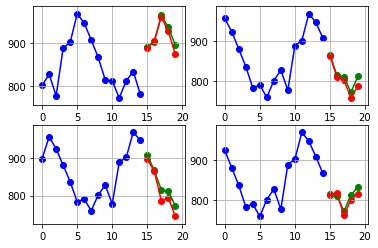

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002730, tr_loss = 0.000092, te_loss = 0.000369
grad_step = 002760, tr_loss = 0.000096, te_loss = 0.000369
grad_step = 002790, tr_loss = 0.000132, te_loss = 0.000369


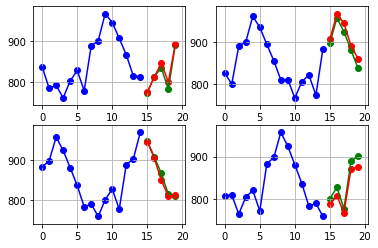

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002820, tr_loss = 0.000083, te_loss = 0.000247
grad_step = 002850, tr_loss = 0.000219, te_loss = 0.000247
grad_step = 002880, tr_loss = 0.000081, te_loss = 0.000247


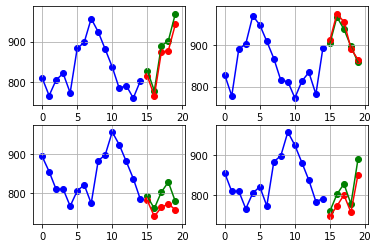

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002910, tr_loss = 0.000097, te_loss = 0.000337
grad_step = 002940, tr_loss = 0.000084, te_loss = 0.000337
grad_step = 002970, tr_loss = 0.000072, te_loss = 0.000337
grad_step = 003000, tr_loss = 0.000094, te_loss = 0.000337


In [8]:
# training
# model seems to converge well around ~2500 grad steps and starts to overfit a bit after.
test_losses = []
for i in range(30):
    eval_test(backcast_length, forecast_length, net, norm_constant, test_losses, x_test, y_test)
    train_100_grad_steps(data, device, net, optimiser, test_losses)